# Makespan policies

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware makespan policies.

## Import statements

In [1]:
from plotting_utils import *
from utils import get_logfile_paths_helper, makespan_fn, prune

## Get list of relevant logfiles and define label mapping

In [2]:
def get_logfile_paths(directory_name, static_trace=False):
    logfile_paths = []
    import re
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/'
             'num_sub_problems=(\d+)/seed=(\d+)/'
             'num_total_jobs=(\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        num_sub_problems = int(m.group(5))
        seed = int(m.group(6))
        num_total_jobs = float(m.group(7))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              num_total_jobs, num_sub_problems, logfile_path))
    return logfile_paths

In [3]:
logfile_paths = sorted(
    get_logfile_paths(
        "/lfs/1/deepak/logs/num_sub_problems_static_sweep/", static_trace=True))

In [4]:
labels = {"min_total_duration_perf": "POP",
          "min_total_duration_packed": "POP"}

## Plotting functions

In [5]:
def plot_metric_vs_num_total_jobs(logfile_paths,
                                  labels,
                                  v100s, p100s, k80s, policies, metric_fn,
                                  metric_label, xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"num_total_jobs": [], "metric": [], "seed": [],
            "policy": []}
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy,
            num_sub_problems_provided=True)))
        num_total_jobs = [x[0] for x in relevant_logfile_paths]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        all_num_sub_problems = [x[3] for x in relevant_logfile_paths]
        policies_with_sub_problems = [labels[policy] + " (%d)" % num_sub_problems if num_sub_problems > 1
                                      else "Original"
                                      for num_sub_problems in all_num_sub_problems]

        import pandas as pd
        data["num_total_jobs"] += num_total_jobs
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies_with_sub_problems
    import pandas as pd
    df = pd.DataFrame(data)
    print(df.groupby(["policy", "num_total_jobs"]).mean())

    sns.lineplot(x='num_total_jobs', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Number of jobs")
    ax.set_ylabel(metric_label)
    ax.set_xlim([70, xmax])
    ax.set_xticks([100, 200, 300, 400, 500, 600, 700])
    sns.despine()
    
    leg = plt.legend(frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

## Plot makespan vs. number of jobs

                             metric  seed
policy   num_total_jobs                  
Original 100.0           162.443708     1
         200.0           162.662470     1
         300.0           162.909686     1
         400.0           162.966511     1
         500.0           185.766189     1
         600.0           222.373590     1
         700.0           273.427585     1
POP (2)  100.0           162.435346     1
         200.0           162.587449     1
         300.0           162.699778     1
         400.0           164.157483     1
         500.0           187.895774     1
         600.0           223.041518     1
         700.0           273.621989     1
POP (4)  100.0           162.435319     1
         200.0           162.575729     1
         300.0           164.335027     1
         400.0           168.835006     1
         500.0           191.084714     1
         600.0           224.476269     1
         700.0           263.010003     1


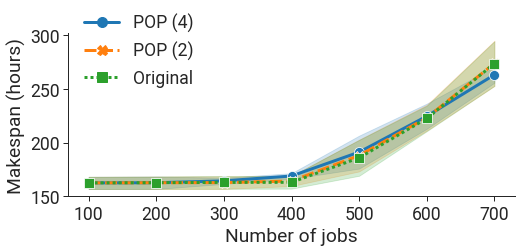

In [6]:
plot_metric_vs_num_total_jobs(
    logfile_paths,
    labels,
    v100s=32, p100s=32, k80s=32,
    policies=["min_total_duration_perf"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    output_filename="num_sub_problems_sweep/min_total_duration_perf.pdf"
)